In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs

In [2]:
# (2)
N=100

ellipse=np.zeros((N+1,2))
for i in range(N+1):
    theta=( -1 * np.pi )/ 4 + (( 11 * np.pi ) / ( 12 * N ) * i)
    ellipse[i][0]=200*np.cos(theta)
    ellipse[i][1]=150*np.sin(theta)

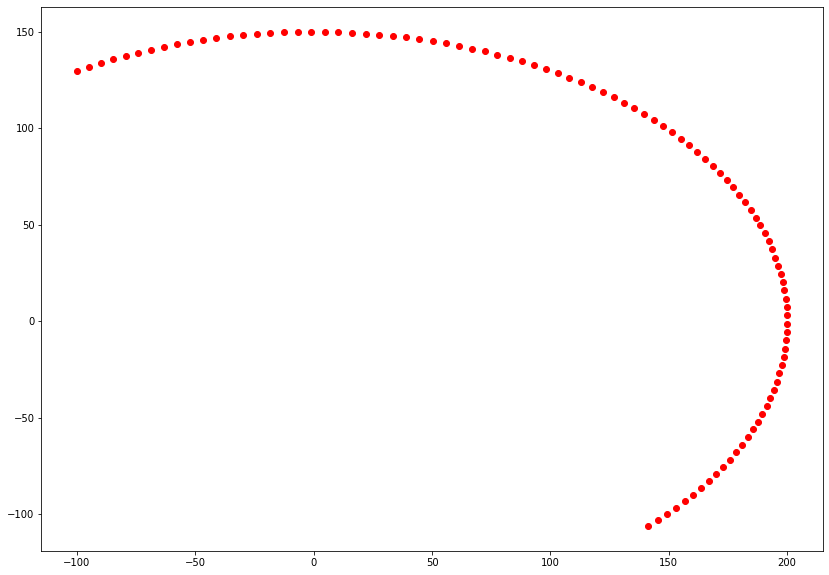

In [3]:
plt.figure(figsize=(14, 10))
plt.plot(ellipse[:, 0], ellipse[:, 1], color="red", linestyle="None", marker='o')

In [4]:
# (3)
sample=np.zeros((N+1,2))
for i in range(N+1):
    sample[i][0]=ellipse[i][0]+random.gauss(0,sigma=2.0)
    sample[i][1]=ellipse[i][1]+random.gauss(0,sigma=2.0)

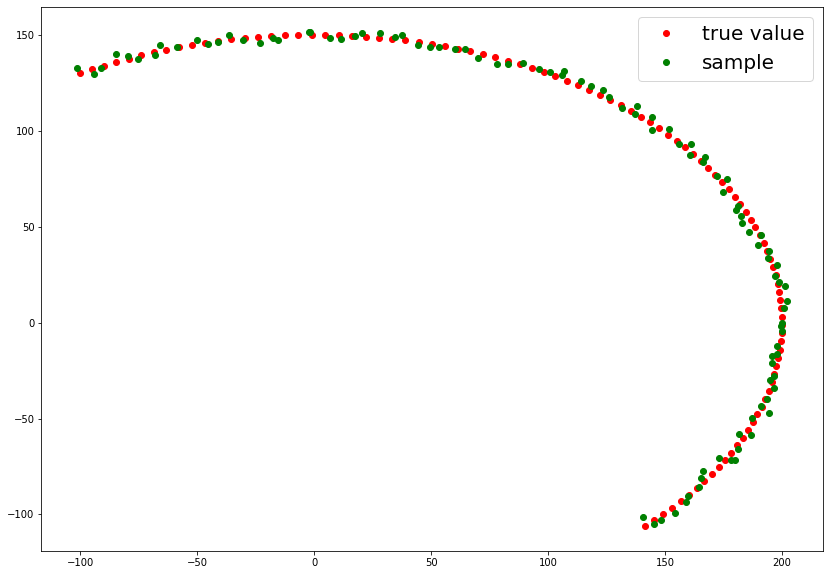

In [5]:
plt.figure(figsize=(14, 10))
plt.plot(ellipse[:, 0], ellipse[:, 1], color="red", linestyle="None", marker='o')
plt.plot(sample[:, 0], sample[:, 1], color="green", linestyle="None", marker='o')
plt.legend(["true value","sample"],loc="best",fontsize=20)

In [6]:
# (4)
sigma_num=20
generate_num=1000
N=100

# sigmaの値を変化させた1000個ずつのデータの生成
sample=np.zeros((sigma_num,generate_num,N+1,2))
for i in range(sigma_num):
    sigma=0.1+(i*0.1)
    for j in range(generate_num):
        for k in range(N+1):
            sample[i][j][k][0]=ellipse[k][0]+random.gauss(0,sigma=sigma)
            sample[i][j][k][1]=ellipse[k][1]+random.gauss(0,sigma=sigma)


In [7]:
sample[10][0][0][0],sample[10][0][0][1]

(141.9651653648981, -106.70128446313174)

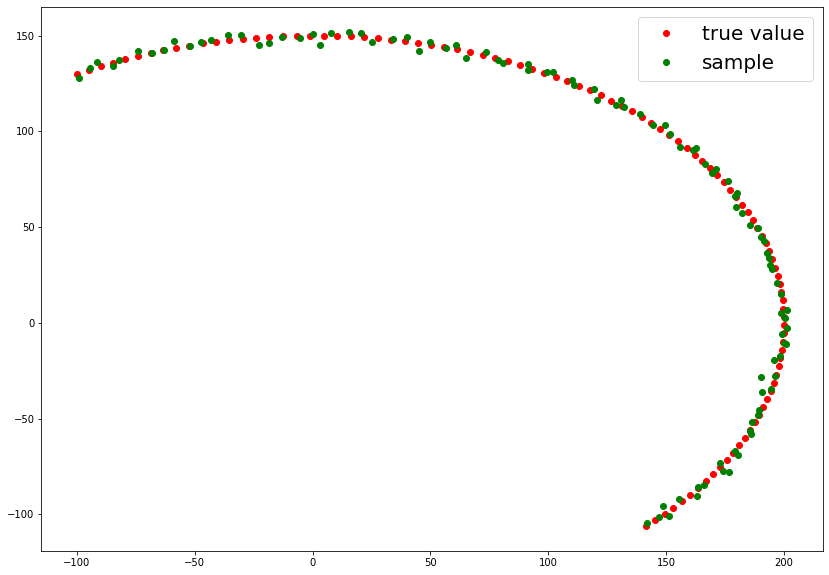

In [8]:
plt.figure(figsize=(14, 10))
plt.plot(ellipse[:, 0], ellipse[:, 1], color="red", linestyle="None", marker='o')
plt.plot(sample[19,0,:, 0], sample[19,0,:, 1], color="green", linestyle="None", marker='o')
plt.legend(["true value","sample"],loc="best",fontsize=20)

In [93]:
def coordinate_param(x,y):
    return np.array([x*x,2.*x*y,y*y,2.*x,2.*y,1.]).T

In [94]:
def matrix_M(coordinate):
    matrix=np.zeros([6,6])
    for i in range(N+1):
        x,y=coordinate[i][0],coordinate[i][1]
        x_alpha=coordinate_param(x,y)
        matrix+=np.outer(x_alpha,x_alpha)
    return matrix

In [95]:
#楕円の真のパラメータを計算
m=matrix_M(ellipse)
value,vector=eigs(m,1,which="SM")
#U_bar=vector.reshape([6])
U_bar=np.array([[(1/150)**2, 0, (1/200)**2, 0, 0, -1]])
value,vector,np.linalg.norm(vector,ord=1)
#真の楕円のパラメータ
#u_bar=np.array([2.5*(10**(-5)),4.4*(10**(-5)),0,0,0,-1])

(array([1.02873389e-06+0.j]),
 array([[-2.50000000e-05+0.j],
        [-4.87577569e-14+0.j],
        [-4.44444445e-05+0.j],
        [ 7.35423758e-12+0.j],
        [ 7.91323265e-12+0.j],
        [ 9.99999999e-01+0.j]]),
 1.000069443159681)

In [96]:
# 楕円のパラメータを計算
U=np.zeros([sigma_num,generate_num,6])
for i in range(sigma_num):
    for j in range(generate_num):
        m=matrix_M(sample[i][j])#行列Mの計算
        value,vector=eigs(m,1,which ="SM") #行列Mに対する最小固有値とそれに対応する固有ベクトル
        U[i][j]=U[i][j]+vector.reshape([6])
        

/var/folders/5q/gwhjzy5s4nl5rhb5x_hsv9z40000gn/T/ipykernel_1781/1586157338.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  U[i][j]=U[i][j]+vector.reshape([6])


In [97]:
# RMS誤差の測定
P_u=np.identity(6)-np.outer(U_bar,U_bar)
error=np.zeros([3,sigma_num,2])
for i in range(sigma_num):
    delta_u=np.zeros([generate_num,6,6])
    for j in range(generate_num):
        delta_u[j]=delta_u[j]+np.matmul(P_u,U[i][j])
    rms=0.
    for j in range(generate_num):
        rms+=(np.linalg.norm(delta_u[j],ord=2))**2
    rms=np.sqrt(rms/generate_num)
    error[0][i][0]=0.1+0.1*i
    error[0][i][1]=rms


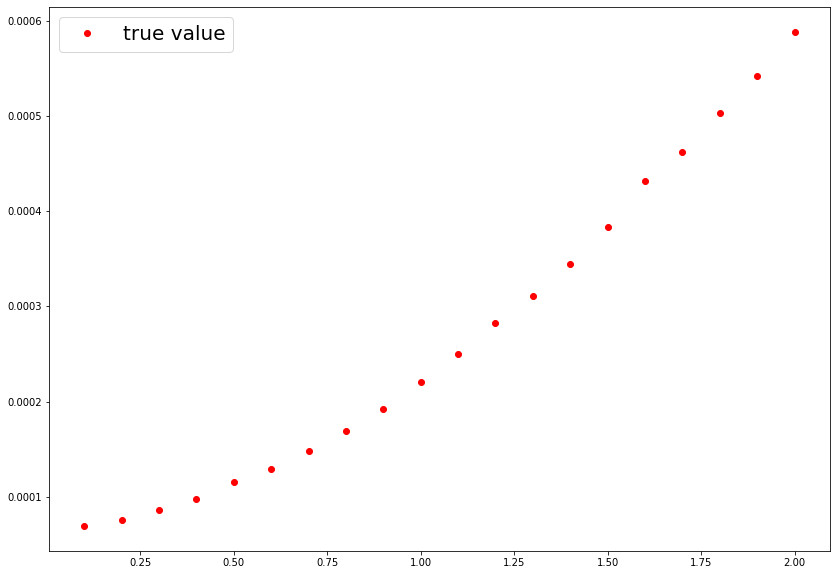

In [98]:
plt.figure(figsize=(14, 10))
plt.plot(error[0,:, 0], error[0,:, 1], color="red", linestyle="None", marker='o')
plt.legend(["true value","sample"],loc="best",fontsize=20)

In [99]:
# 最尤推定の実装

def coordinate_param(x,y):
    return np.array([[x*x,2.*x*y,y*y,2.*x,2.*y,1.]]).T

#共分散行列Vの計算
def covariance(x,y,sigma):
    matrix=np.array([
        [x*x,   x*y,            0,      x, 0, 0],
        [x*y,   (x*x)+(y*y),    x*y,    y, x, 0],
        [0,     x*y,            y*y,    0, y, 0],
        [x,     y,              0,      1, 0, 0],
        [0,     x,              y,      0, 1, 0],
        [0,     0,              0,      0, 0, 0]
    ])
    matrix=matrix*4*sigma*sigma
    return matrix 

#行列Mの計算
def matrix_M(coordinate,u,sigma):
    matrix=np.zeros((6,6))
    for i in range(len(coordinate)):
        x,y=coordinate[i][0],coordinate[i][1]
        ksi=coordinate_param(x,y)
        v=covariance(x,y,sigma)
        #分子
        #numerator=np.outer(ksi,ksi)     
        #分母
        #denominator=np.matmul(covariance(x,y,sigma),u)
        #denominator=np.dot(u,denominator)
        #matrix=matrix+(numerator/denominator)
        if u.T.dot(v.dot(u))==0:
            matrix=matrix+ksi.dot(ksi.T)
        else:
            matrix=matrix+ksi.dot(ksi.T)/ u.T.dot(v.dot(u))
    return matrix

#行列Lの計算
def matrix_L(coordinate,u,sigma):
    matrix=np.zeros([6,6])
    for i in range(len(coordinate)):
        x,y=coordinate[i][0],coordinate[i][1]
        ksi=coordinate_param(x,y)
        v=covariance(x,y,sigma)
        #分子
        #numerator=np.dot(ksi,u)**2
        #numerator=numerator*v
        #分母
        #denominator=np.matmul(v,u)
        #denominator=np.dot(u,denominator)**2
        #matrix=matrix+(numerator/denominator)
        if u.T.dot(v.dot(u))==0:
            matrix=matrix+(ksi.T.dot(u))**2*v
        else:
            matrix=matrix+((ksi.T.dot(u))**2*v /u.T.dot(v.dot(u))**2) 
    return matrix
    



In [100]:
u=np.array([1.,1.,1.,1.,1.,1.,])
matrix_M(sample[0][0],u,0.1)-matrix_L(sample[0][0],u,0.1)

array([[ 3.07402384e+07, -3.55442829e+07,  1.66081551e+07,
         3.50140330e+05, -6.73369854e+04,  1.82875412e+03],
       [-3.55442829e+07,  4.65913017e+07, -2.92719150e+07,
        -1.74055365e+05, -9.50052819e+04, -2.13909599e+03],
       [ 1.66081551e+07, -2.92719150e+07,  1.86571517e+07,
        -1.33005580e+04,  2.10137271e+05,  1.55345036e+03],
       [ 3.50140330e+05, -1.74055365e+05, -1.33005580e+04,
         6.68376648e+03, -4.27819199e+03,  9.87276099e+00],
       [-6.73369854e+04, -9.50052819e+04,  2.10137271e+05,
        -4.27819199e+03,  5.58255144e+03,  9.40400131e+00],
       [ 1.82875412e+03, -2.13909599e+03,  1.55345036e+03,
         9.87276099e+00,  9.40400131e+00,  1.14753225e-01]])

In [101]:
# 楕円のパラメータを計算
U=np.zeros((sigma_num,generate_num,6))
U_bar=np.array([[(1/150)**2, 0, (1/200)**2, 0, 0, -1]])
for i in range(7,11):
    sigma=0.1*i+0.1
    for j in range(generate_num):
        print("sigma:{0} {1}個終了".format(sigma,j))
        #u=np.random.rand(6)
        #u=np.array([1.,1.,1.,1.,1.,1.])
        u=np.zeros((6,1))
        u0=np.zeros((6,1))
        k=0
        while True:
            k+=1
            #m_sub_l=matrix_M(sample[i][j],u0,sigma)-matrix_L(sample[i][j],u0,sigma)
            m=matrix_M(sample[i][j],u0,sigma)
            l=matrix_L(sample[i][j],u0,sigma)
            #value,vector=eigs(m_sub_l,1,which ="SM") #行列Mに対する最小固有値とそれに対応する固有ベクトル
            value,vector=np.linalg.eig(m-l)
            index=np.abs(value).argsort()[0]
            u=np.atleast_2d(vector[:,index]).T
            if np.linalg.norm(u0-u,ord=2)<0.0001:
                break
            print("{}: {:.8f}".format(k,np.linalg.norm(u-u0,ord=2)))
            u0=u
        U[i][j]=u.reshape((6))

sigma:0.8 0個終了
1: 1.00000000
sigma:0.8 1個終了
1: 1.00000000
sigma:0.8 2個終了
1: 1.00000000
sigma:0.8 3個終了
1: 1.00000000
sigma:0.8 4個終了
1: 1.00000000
sigma:0.8 5個終了
1: 1.00000000
sigma:0.8 6個終了
1: 1.00000000
sigma:0.8 7個終了
1: 1.00000000
sigma:0.8 8個終了
1: 1.00000000
sigma:0.8 9個終了
1: 1.00000000
sigma:0.8 10個終了
1: 1.00000000
sigma:0.8 11個終了
1: 1.00000000
sigma:0.8 12個終了
1: 1.00000000
sigma:0.8 13個終了
1: 1.00000000
sigma:0.8 14個終了
1: 1.00000000
sigma:0.8 15個終了
1: 1.00000000
sigma:0.8 16個終了
1: 1.00000000
sigma:0.8 17個終了
1: 1.00000000
sigma:0.8 18個終了
1: 1.00000000
sigma:0.8 19個終了
1: 1.00000000
sigma:0.8 20個終了
1: 1.00000000
sigma:0.8 21個終了
1: 1.00000000
sigma:0.8 22個終了
1: 1.00000000
sigma:0.8 23個終了
1: 1.00000000
sigma:0.8 24個終了
1: 1.00000000
sigma:0.8 25個終了
1: 1.00000000
sigma:0.8 26個終了
1: 1.00000000
sigma:0.8 27個終了
1: 1.00000000
sigma:0.8 28個終了
1: 1.00000000
sigma:0.8 29個終了
1: 1.00000000
sigma:0.8 30個終了
1: 1.00000000
sigma:0.8 31個終了
1: 1.00000000
sigma:0.8 32個終了
1: 1.00000000
sigma:0.8 33個終了
1: 1

In [102]:
# RMS誤差の測定
P_u=np.identity(6)-U_bar.T.dot(U_bar)
for i in range(sigma_num):
    #delta_u=np.zeros([generate_num,6,6])
    #for j in range(generate_num):
    #    delta_u[j]=delta_u[j]+np.matmul(P_u,U[i][j])
    #rms=0.
    #for j in range(generate_num):
    #    rms+=(np.linalg.norm(delta_u[j],ord=2))**2
    #rms=np.sqrt(rms/generate_num)
    for j in range(generate_num):
        delta_u=P_u.dot(U[i][j])
        error[1][i][0]=0.1+0.1*i
        error[1][i][1]=(np.linalg.norm(delta_u,ord=2)/generate_num)


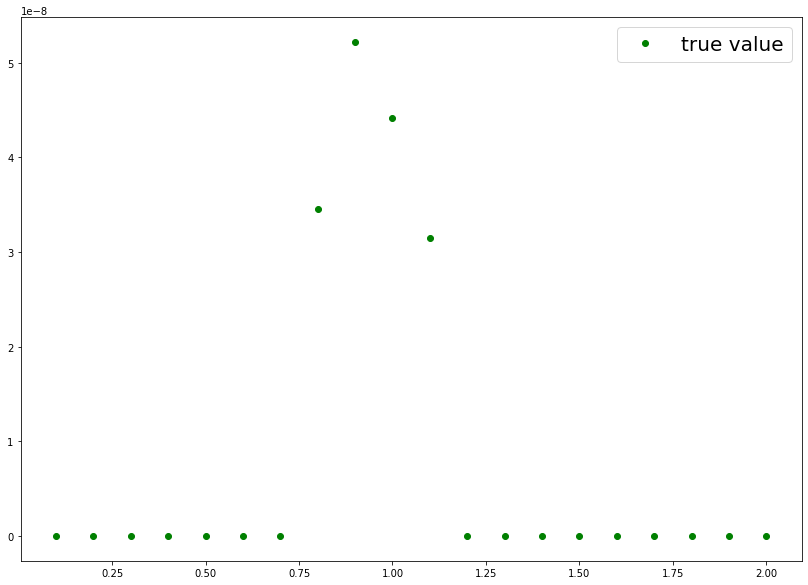

In [104]:
plt.figure(figsize=(14, 10))
plt.plot(error[1,:, 0], error[1,:, 1], color="green", linestyle="None", marker='o')
plt.legend(["true value","sample"],loc="best",fontsize=20)